In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida (archivo class_09.csv), obtenga el modelo estimado usando el modelo ARMAX.

**Paso 1: Lectura de los datos**

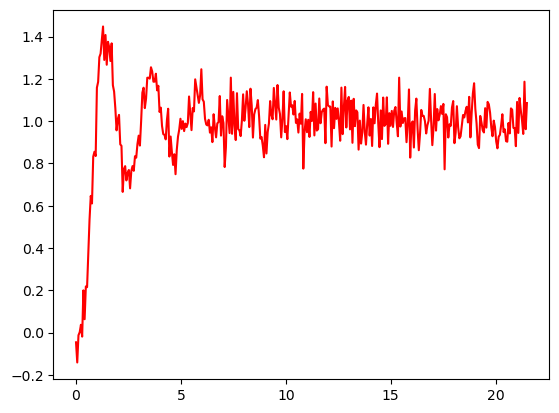

In [2]:
datos = pd.read_csv ('data\clase_09.csv')
t = datos.t
yn = datos.yn
N = len(t)
u = np.ones(N)
plt.plot(t,yn,color = 'red')
dt = (t[1] - t[0])


## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1]]$$

In [11]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran

y_1 = np.zeros(N)
y_2 = np.zeros(N)
y_3 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
u_3 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
for k in range(3,N):
    y_3[k]=yn[k-3]
    u_3[k]=u[k-3]

## Creación del vector phi
phi = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 1
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.30149959, -0.30996043, -0.2134142 , -0.02007918,  0.08745776,
        0.1104929 ])

## Armando la función estimada ARX

**Paso 3:** Definir la función de transferencia estimada $G_e$

In [12]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2 + theta[2]*z**-3 
B =  theta[3]*z**-1 +theta[4]*z**-2+theta[5]*z**-3  

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

print(G)

(0.0200791770782871*z**2 - 0.0874577608525442*z - 0.110492897928594)/(-z**3 + 0.301499590631096*z**2 + 0.309960425643648*z + 0.213414199317314)


## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.


-0.02008 z^2 + 0.08746 z + 0.1105
----------------------------------
z^3 - 0.3015 z^2 - 0.31 z - 0.2134

dt = 0.058560672725574976



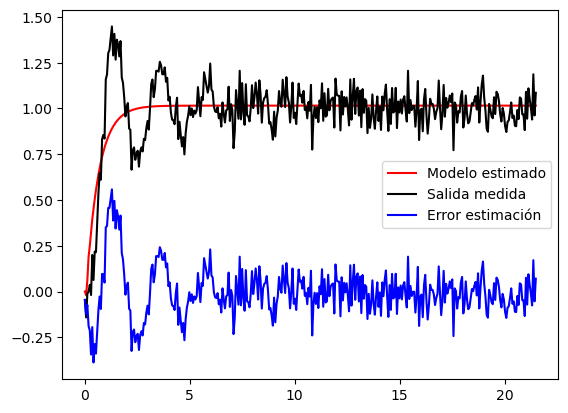

In [13]:
## Definiendo la función de transferencia estimada ARX
G_e = control.tf([theta[3],theta[4],theta[5]],[1,theta[0],theta[1],theta[2]],dt)
_,ye = control.step_response(G_e,t)

## Ganancia de ajuste
k = 1;
ye = k*ye

## Señal de error estimado
e = yn-ye

plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.plot(t,e,color = 'blue')
plt.legend(['Modelo estimado','Salida medida','Error estimación'])

print(G_e)

## Planteando el nuevo regresor

**Paso 5:** Se va propone un nuevo regresor que incluya la señal de error estimada en el paso anterior

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3],e[k-1],e[k-2],e[k-3]]$$

In [18]:
e_1 = np.zeros(N)
e_2 = np.zeros(N)
e_3 = np.zeros(N)

for k in range(1,N):
    e_1[k]=e[k-1]
for k in range(2,N):
    e_2[k]=e[k-2]
for k in range(3,N):
    e_3[k]=e[k-3]
## Creación del vector phi
phi2 = np.array([-y_1,-y_2,-y_3,u_1,u_2,u_3,e_1,e_2,e_3]).transpose()

# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0.05
Am = np.dot(phi2.T,phi2) + alpha*np.eye(len(np.dot(phi2.T,phi2)))
theta2 = np.dot(np.linalg.inv(Am),np.dot(phi2.T,yn))
theta2

array([-0.31905452, -0.32043464, -0.20758822, -0.11333048,  0.1583024 ,
        0.11121795, -0.00228405,  0.00635377, -0.02161284])

In [19]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2+ theta[2]*z**-3  
B = theta[3]*z**-1+theta[4]*z**-2+theta[5]*z**-3 
C = 1 + theta[6]*z**-1 + theta[7]*z**-2 + theta[8]*z**-3 
G = B/A
print(G)


  -0.1133 z^2 + 0.1583 z + 0.1112
------------------------------------
z^3 - 0.3191 z^2 - 0.3204 z - 0.2076

dt = 0.058560672725574976



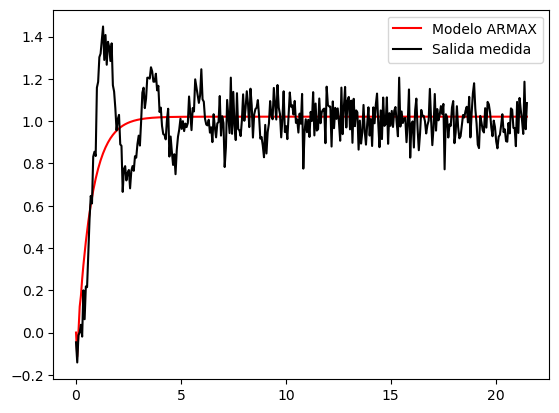

In [23]:
## Armando la función de transferencia estimada con los parámetros hallados
G2 = control.tf([theta[3],theta[4],theta[5]],[1,theta[0],theta[1],theta[2]],dt)
print(G2)
## Se determina la respuesta estimada al escalón
_,y2 = control.step_response(G2,t)

e2 = yn-y2

plt.plot(t,y2,color = 'red')
plt.plot(t,yn,color = 'black')
#plt.plot(t,e2,color = 'green')

plt.legend(['Modelo ARMAX','Salida medida','Error estimacion'])

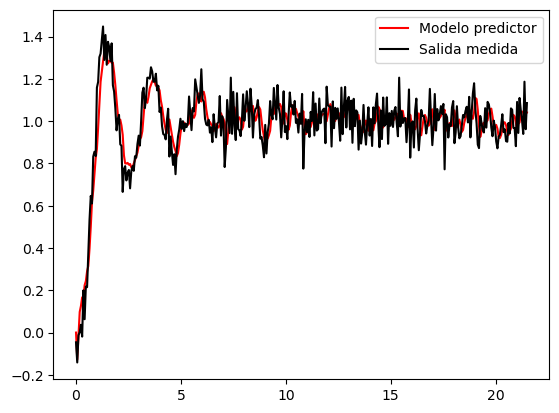

In [22]:
## Armando la función estimada con los parámetros hallados y usando el predictor.

yf = -theta[0]*y_1-theta[1]*y_2-theta[2]*y_3+theta[3]*u_1+theta[4]*u_2+theta[5]*u_3+theta[6]*e_1+theta[7]*e_2+theta[8]*e_3  
plt.plot(t,yf,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo predictor','Salida medida'])